In [3]:
import pandas as pd
import cv2
import numpy as np

In [4]:
data_frame = pd.read_csv('data_tables/all_data.csv')

In [5]:
def crop_jcuh_videos(frame):
    cropped_scan_area = frame[60:520, 300:620]
    return cropped_scan_area

In [6]:
def crop_mft_videos(frame, video_path):
    crop_coords_df = pd.read_csv('mft_video_crop_coordinates.csv')

    for index, row in crop_coords_df.iterrows():
        if row['video_path'] in video_path:
            x_1, y_1, x_2, y_2 = row['x_start'], row['y_start'], row['x_end'], row['y_end']
            scan_area_cropped = frame[y_1:y_2, x_1:x_2]
            return scan_area_cropped

In [7]:
def crop_uhw_videos(frame, rel_x=0.2938, rel_y=0.1917, rel_w=0.4125, rel_h=0.8083):
    height, width, channels = frame.shape
    x = int(rel_x * width)
    y = int(rel_y * height)
    w = int(rel_w * width)
    h = int(rel_h * height)
    scan_area_cropped = frame[y:y+h, x:x+w]
    return scan_area_cropped

In [8]:
def crop_frame(frame, video_path):
    if 'MFT' in video_path:
        return crop_mft_videos(frame, video_path)
    elif 'JCUH' in video_path:
        return crop_jcuh_videos(frame)
    elif 'UHW' in video_path:
        return crop_uhw_videos(frame)
    else:
        return frame  # return original frame if no cropping rules apply

In [9]:
def extract_frame(video_path, frame_number=0):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # only extract frames for videos in data_frame where column 'neglect' is not True
    if 'is_duplicate' in data_frame.columns:
        video_record = data_frame[data_frame['File Path'] == video_path]
        if not video_record.empty and video_record.iloc[0]['is_duplicate'] == True:
            return []
        
    if 'no_score' in data_frame.columns:
        video_record = data_frame[data_frame['File Path'] == video_path]
        if not video_record.empty and video_record.iloc[0]['no_score'] == True:
            return []
        
    if 'M-mode scan' in data_frame.columns:
        video_record = data_frame[data_frame['File Path'] == video_path]
        if not video_record.empty and video_record.iloc[0]['M-mode scan'] == True:
            return []

    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # print(f"Total frames: {total_frames}")
    # print(f"FPS: {fps}")
    
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read frame
    ret, frame = cap.read()
    
    if not ret or frame is None:
        print("Error: Could not read frame.")
        return None, total_frames, fps
    
    
    # crop frame to scan area
    frame = crop_frame(frame, video_path)
    
    # cut top 25% off frame
    frame_height = frame.shape[0]
    frame = frame[int(0.25 * frame_height):, :]
    
    
    
    # Release video capture object
    cap.release()

    return frame, total_frames, fps


In [10]:
# find the variance in mean pixel value for a video
# find the variance in mean pixel value for a video
def calculate_video_stats(video_path):
    # Open the video file to get total frames
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    
    mean_values = []
    frame_variance = []   
    
    # Loop through all frames in the video
    for frame_num in range(total_frames):
        frame_data = extract_frame(video_path, frame_number=frame_num)
        if not frame_data or frame_data[0] is None:
            continue
            
        frame = frame_data[0]
        
        mean_pixel_value = np.mean(frame)
        frame_std_dev_value = np.std(frame)
        mean_values.append(mean_pixel_value)
        frame_variance.append(frame_std_dev_value)

    # Calculate variance of means across all frames
    variance_of_means = np.std(mean_values)
    average_frame_variance = np.mean(frame_variance)
    return variance_of_means, average_frame_variance

# video_variance = calculate_video_stats(video_path)
# print("Variance of mean pixel values across video frames:", video_variance[0], "Average variance of pixel values within frames:", video_variance[1])

# video_variance = calculate_video_stats(video_path)
# print("Variance of mean pixel values across video frames:", video_variance[0], "Average variance of pixel values within frames:", video_variance[1])

In [11]:
from tqdm import tqdm

df_loaded = pd.read_csv('data_tables/all_data.csv')

sample_df = df_loaded.sample(n=200)

videos = []
for vp in tqdm(sample_df['File Path'].tolist()):
    video_path=vp
    stats = calculate_video_stats(video_path)

    if stats is None:
        continue
        
    # Extract all frame variances and video variances for normalization
    frame_vars = stats[1] 
    video_vars = stats[0] 
    
    
# Record all videos in this group with the preferred one
    videos.append({
        'Hospital': sample_df[sample_df['File Path']==video_path]['Hospital'].values[0],
        'Patient ID': sample_df[sample_df['File Path']==video_path]['Patient ID'].values[0],
        'Scan No': sample_df[sample_df['File Path']==video_path]['Scan No'].values[0],
        'Scan Label': sample_df[sample_df['File Path']==video_path]['Scan Label'].values[0],
        'Video Path': video_path,
        'frame_stddev': frame_vars,
        'video_stddev': video_vars,
    })

df_sample = pd.DataFrame(videos)


  0%|          | 1/200 [00:05<16:57,  5.11s/it]/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encounter

In [12]:
print(df_sample)

    Hospital  Patient ID Scan No Scan Label  \
0        MFT           2   LUS_1        RPA   
1        MFT          12    LU_4        LPB   
2       JCUH          31   LUS_1        RAA   
3       JCUH          38   LUS_2        RPA   
4        MFT          35   LUS_3        RAB   
..       ...         ...     ...        ...   
195     JCUH          24   LUS_3        LPA   
196      UHW           5    LU_4        LAX   
197      MFT          26   LUS_2        LAA   
198     JCUH          10    LU_4        LPB   
199     JCUH           1   LUS_1        RPB   

                                            Video Path  frame_stddev  \
0    /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...     23.867153   
1    /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...           NaN   
2    /cosma7/data/dp004/rrtx34/ultrasound/JCUH/031/...           NaN   
3    /cosma7/data/dp004/rrtx34/ultrasound/JCUH/038/...     15.254411   
4    /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...     17.282386   
.. 

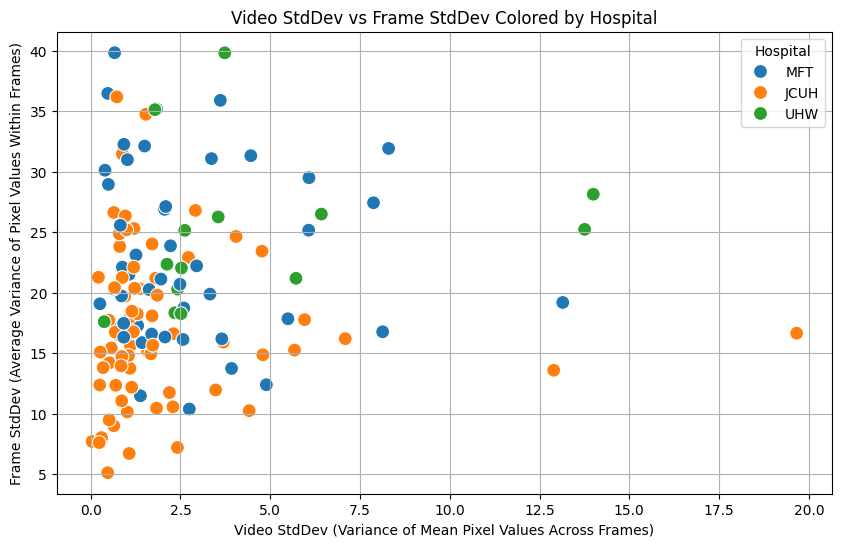

In [13]:
# make a cluster plot of the sample variances for every video in sample_df coloured by hospital
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sample, x='video_stddev', y='frame_stddev', hue='Hospital', s=100)
plt.title('Video StdDev vs Frame StdDev Colored by Hospital')
plt.xlabel('Video StdDev (Variance of Mean Pixel Values Across Frames)')
plt.ylabel('Frame StdDev (Average Variance of Pixel Values Within Frames)')
plt.legend(title='Hospital')
plt.grid(True)
plt.show()  